## 交集面積算法

In [1]:
import pandas as pd
import shapefile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import geopandas as gp
from shapely.geometry import Point
from scipy.spatial import distance

In [2]:
#先讀feature_engineering_example裡的資料
df1 = pd.read_excel('/projectdata/nckugeo01/feature_engineering_example/Dali_completed.xls')

In [3]:
#找一筆測試看看
t = df1[:1]
t

,FID,鄉鎮市,Response_A,總價元,建物現況_房,建物現況_廳,建物現況_衛,Trans_P,Dali_AllRe,Dali_ComRe,...,Dali_Indus,Dali_MixRe,Dali_Pure,Dali_Resta,Dali_Popul,Dali_Major,Dali_Local,Convi_Dis,Trans_Dis,Resta_Dis
0,0,大里區,臺中市大里區內新里19鄰新平街15號,2700000,3,2,2,22,3.830104e+06,761116.537466,...,115261.24915,876377.786616,2.923485e+06,71,150379,3905.930902,82270.796875,129.718167,394.936176,358.544926


In [6]:
#去實價登錄裡面找同一個物件
df2 = pd.read_excel('/projectdata/nckugeo01/實價登錄資料.xls')

In [7]:
df2[df2['Response_Address'] == '臺中市大里區內新里19鄰新平街15號']

,鄉鎮市區,交易標的,土地區段位置或建物區門牌,Last unit,RESULT,REMOVE 號,AVG,門牌,Response_Address,Response_X,...,建物現況格局-衛,建物現況格局-隔間,有無管理組織,總價元,單價每平方公尺,車位類別,車位移轉總面積平方公尺,車位總價元,備註,編號
31,大里區,房地(土地+建物),臺中市大里區新平街1~30號,街,1~30號,1~30,15.5,臺中市大里區新平街16號,臺中市大里區內新里19鄰新平街15號,218890.91,...,2,有,無,2700000,40323.0,NaN,0.0,0,NaN,RPROMLMJNHMFFGL09CA


In [4]:
#讀取 Landuse_area 裡面的 Commercial_Res(兼商業使用住宅)
area = gp.GeoDataFrame.from_file('/projectdata/nckugeo01/Landuse_area/Commercial_Res.shp')

In [5]:
#裡面的 geometry 這個 column 記錄了該商用住宅的範圍
area.columns

Index(['ID', 'LCODE_C1', 'LCODE_C2', 'LCODE_C3', 'METHOD', 'DATATIME',
       'IMTIME_F', 'IMTIME_T', 'ShpName', 'Mddi_org', 'area', 'geometry'],
      dtype='object')

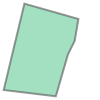

In [6]:
#裡面的資料為 polygon 的物件
#x, y = area.geometry[0].exterior.coords.xy 記錄一下拿 point 的方法
area.geometry[0]

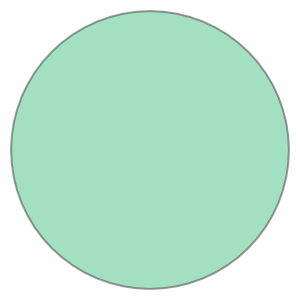

In [7]:
a = Point(218890.91, 2666987.36).buffer(2000) #這個物件的 Response_X 及 Response_Y 以 2000 公尺畫圓
a

In [8]:
d = 0 #最後要計算總面積用的
for i in tqdm(range(len(area.geometry))):
    b = area.geometry[i]
    c = a.intersection(b)
    d += c.area
print('total area by calculate: '+str(d))
print('total area in feature_engineering_example: '+str(t.Dali_ComRe[0]))

HBox(children=(IntProgress(value=0, max=34549), HTML(value='')))


total area by calculate: 760202.8176593131
total area in feature_engineering_example: 761116.537466


## 範圍內含有的POI
- 用便利商店當範例

In [9]:
#讀 POI 的檔近來
df3 = pd.read_excel('/projectdata/nckugeo01/POI_list.xlsx')

In [12]:
#找便利商店出來
p = df3[df3.地標大分類 == '24小時生活便利連鎖商店']
p = p.reset_index()

In [13]:
#同樣用上面那個標的
a = Point(218890.91, 2666987.36).buffer(2000)

In [14]:
count = 0 #用來數有幾間店
for i in tqdm(range(len(p))):
    point = Point(p.X坐標[i],p.Y坐標[i])
    if a.contains(point):
        count+=1
print('numbers of convenience store by calculate: '+str(count))
print('numbers of convenience store in feature_engineering_example: '+str(t.Dali_Convi[0]))

HBox(children=(IntProgress(value=0, max=936), HTML(value='')))


numbers of convenience store by calculate: 66
numbers of convenience store in feature_engineering_example: 66


## 距離最近的POI
- 還是用便利商店當範例
- 這邊有 import 一個 scipy.spatial 裡面的 distance class (在最上面）

In [15]:
#用同樣上面的標的，但這次不用畫圈圈（ya）
ap = (218890.91, 2666987.36)

In [17]:
for i in tqdm(range(len(p))):
    point = (p.X坐標[i],p.Y坐標[i])
    #一筆一筆對，如果是第一筆，就先塞給 min_d
    if i == 0:
        min_d = distance.euclidean(ap,point)
        
    #接下來如果有看到更小的 distance，就更新 min_d
    elif min_d > distance.euclidean(ap,point):
        min_d = distance.euclidean(ap,point)
print('distance between nearset convenience store by calculate: '+str(min_d))
print('distance between nearset convenience store in feature_engineering_example: '+str(t.Convi_Dis[0]))

HBox(children=(IntProgress(value=0, max=936), HTML(value='')))


distance between nearset convenience store by calculate: 129.7177935563325
distance between nearset convenience store in feature_engineering_example: 129.718166922


## 人口
- 跑的時間比較久，可能有其他方法
- 與實際值的差異有點大，先看看座標轉換有沒有辦法解決

In [28]:
#先把人口資料讀進來
people = gp.GeoDataFrame.from_file('/projectdata/nckugeo01/人口_最小統計區/population_最小統計.shp')

In [29]:
#裡面的 geometry 這個 column 記錄了統計的區域，P_CNT 為該區統計出的人數
people.columns

Index(['U_ID', 'CODEBASE', 'CODE1', 'CODE2', 'VILLCODE', 'VILLAGE_ID',
       'VILLAGE', 'TOWN_ID', 'TOWN', 'COUNTY_ID', 'COUNTY', 'USE_CODE', 'LINE',
       'SPECODE', 'X', 'Y', 'AREA', 'M', 'USECODE', 'INFO_TIME', 'CODE2_1',
       'CODE1_1', 'CODEBASE_1', 'P_CNT', 'geometry'],
      dtype='object')

In [48]:
popu = 0 #最後要計算人口的
a = Point(218890.91, 2666987.36).buffer(2000)
for i in tqdm(range(len(people.geometry))):
    b = people.geometry[i]
    c = a.intersection(b)
    rate = c.area / b.area #涵蓋該區的比率
    popu += (people.P_CNT[i] * rate)
print('population by calculate: '+str(popu))
print('population in feature_engineering_example: '+str(t.Dali_Popul[0]))

HBox(children=(IntProgress(value=0, max=17218), HTML(value='')))


population by calculate: 157432.457144
population in feature_engineering_example: 150379


## 區域內道路長
- 以主要道路為例子
- 與實際值差異也有點大，同樣看座標能不能解決

In [9]:
#先讀資料進來
r = shapefile.Reader("/projectdata/nckugeo01/道路_length/Major_road.sbn")

In [10]:
shapes = r.shapes()

In [11]:
shapes[0]

In [14]:
leng = 0
a = Point(218890.91, 2666987.36).buffer(2000)
for i in tqdm(range(len(shapes))):
    point_min = Point(shapes[i].bbox[0],shapes[i].bbox[1])
    point_max = Point(shapes[i].bbox[2],shapes[i].bbox[3])
    
    if a.contains(point_min) & a.contains(point_max):
        leng+=r.records()[i][-1]
        
    elif a.contains(point_min):
        point_a = []
        for j in shapes[i].points:
            point = Point(j)
            if a.contains(point):
                point_a.append(j)
            if len(point_a)>1:
                for k in range(len(point_a)-1):
                    leng += distance.euclidean(point_a[k],point_a[k+1]) 

    elif a.contains(point_max):
        point_a = []
        for j in shapes[i].points:
            point = Point(j)
            if a.contains(point):
                point_a.append(j)
            if len(point_a)>1:
                for k in range(len(point)-1):
                    leng += distance.euclidean(point_a[k],point_a[k+1]) 
    else:
        point_min_sp = Point(shapes[i].bbox[2],shapes[i].bbox[1])
        if a.contains(point_min_sp):
            print('in else')
            point_a = []
            for j in shapes[i].points:
                point = Point(j)
                if a.contains(point):
                    point_a.append(j)
                if len(point_a)>1:
                    for k in range(len(point)-1):
                        leng += distance.euclidean(point_a[k],point_a[k+1])
                    
print('length by calculate: '+str(leng))
print('length in feature_engineering_example: '+str(t.Dali_Major[0]))

HBox(children=(IntProgress(value=0, max=3032), HTML(value='')))


length by calculate: 3738.910193909505
length in feature_engineering_example: 3905.93090221


In [45]:
leng = 0
a = Point(218890.91, 2666987.36).buffer(2000)
for i in tqdm(range(len(shapes))):
    for j in range(len(shapes[i].points)-1):
        point = Point(shapes[i].points[j])
        point2 = Point(shapes[i].points[j+1])
        if a.contains(point) & a.contains(point2):
            line = LineString([point, point2])
            #leng += distance.euclidean(point,point2) 
            leng += line.length
        elif a.contains(point):
            line = LineString([point, point2])
            leng += line.intersection(a).length
        elif a.contains(point2):
            line = LineString([point, point2])
            print(line)
            leng += line.intersection(a).length

print('length by calculate: '+str(leng))
print('length in feature_engineering_example: '+str(t.Dali_Major[0]))

HBox(children=(IntProgress(value=0, max=3032), HTML(value='')))

LINESTRING (217404.9499997826 2668334.359997332, 217404.9099997826 2668315.859997332)
LINESTRING (218897.3822382774 2664985.539647516, 218885.4702382774 2664998.237447516)

length by calculate: 3902.1851060498047
length in feature_engineering_example: 3905.93090221
